# SIR using curve_fit
 ref: https://www.kaggle.com/c/covid19-global-forecasting-week-1/discussion/137796

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, optimize
import pandas as pd
df= pd.read_csv("../countries-spread-rate/confirmed-data-top-affected-countries.csv")
df["Country"].values

array(['China', 'Italy', 'Spain', 'Germany', 'Iran', 'US', 'France',
       'Korea, South', 'Switzerland', 'United Kingdom', 'Netherlands',
       'Austria', 'Belgium', 'Norway', 'Sweden', 'Denmark', 'Malaysia',
       'Portugal', 'Japan', 'Canada', 'Czechia', 'Brazil', 'Australia',
       'Cruise Ship', 'Israel', 'Ireland', 'Pakistan', 'Greece',
       'Luxembourg', 'Qatar', 'Finland', 'Chile', 'Poland', 'Iceland',
       'Singapore', 'Indonesia', 'Ecuador', 'Turkey', 'Saudi Arabia',
       'Slovenia', 'Thailand', 'Romania', 'Bahrain', 'Egypt', 'Estonia',
       'Russia', 'India', 'Peru', 'Philippines', 'Iraq', 'South Africa',
       'Mexico', 'Lebanon', 'Kuwait', 'San Marino', 'Panama', 'Taiwan*',
       'Argentina'], dtype=object)

In [2]:
df.head()

,Country,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20
0,China,548,643,920,1406,2075,2877,5509,6087,8141,...,80945,80977,81003,81033,81058,81102,81156,81250,81305,81397
1,Italy,0,0,0,0,0,0,0,0,0,...,17660,21157,24747,27980,31506,35713,41035,47021,53578,59138
2,Spain,0,0,0,0,0,0,0,0,0,...,5232,6391,7798,9942,11748,13910,17963,20410,25374,28768
3,Germany,0,0,0,0,0,1,4,4,4,...,3675,4585,5795,7272,9257,12327,15320,19848,22213,24873
4,Iran,0,0,0,0,0,0,0,0,0,...,11364,12729,13938,14991,16169,17361,18407,19644,20610,21638


In [3]:
df_pop=pd.read_csv("population_by_country_2020.csv")
df_pop.head()


,Country (or dependency),Population (2020),Yearly Change,Net Change,Density (P/Km²),Land Area (Km²),Migrants (net),Fert. Rate,Med. Age,Urban Pop %,World Share
0,China,1439323776,0.39%,5540090,153,9388211,-348399.0,1.7,38,61%,18.47%
1,India,1380004385,0.99%,13586631,464,2973190,-532687.0,2.2,28,35%,17.70%
2,United States,331002651,0.59%,1937734,36,9147420,954806.0,1.8,38,83%,4.25%
3,Indonesia,273523615,1.07%,2898047,151,1811570,-98955.0,2.3,30,56%,3.51%
4,Pakistan,220892340,2.00%,4327022,287,770880,-233379.0,3.6,23,35%,2.83%


In [46]:
import itertools
marker = itertools.cycle(( '*','+', '.', 'o', '*')) 
def seir(y, x, R0, Tr, Tl):
    gamma=1./Tr
    beta=R0*gamma
    sigma=1./Tl
    sus = -beta*y[0]*y[2]/N
    expo = (beta*y[0]*y[2]/N)-sigma*y[1]
    infected = sigma*y[1] - gamma*y[2]
    reco = gamma*y[2]
    return sus, expo, infected, reco
## 5.5 tl, 2.5 tr
def fit_ode(x,  R0, Tr, Tl):
    y= integrate.odeint(seir, (sus0, exp0, inf0, rec0), x, args=( R0, Tr, Tl))
    #return y[:,2] + y[:,3]
    return y[:,3]
def fit_country(country,population,bounds=([3,7,2], [10,10,3])):#([3,7,2], [10,10,3]))([1,1,1],[15,15,15]): #2-3, T_R=7-10. And R_0=3-10
    ydata= df[df["Country"]==country].values[0,1:]
    ydata = np.array(ydata, dtype=float)
    #xdata = np.array(xdata, dtype=float)
    idx=np.where(ydata>50)[0][0]
    ydata=ydata[idx:]
    xdata= np.arange(len(ydata))  #+ idx
#    xdata=xdata[idx:]
    global N, inf0, sus0,rec0,exp0
    #print(xdata,ydata)
    N = population
    '''
    inf0 = ydata[0]
    sus0 = N - inf0 -inf0*5
    rec0 = 0.0
    exp0= inf0*5
    '''
    
    rec0 = ydata[0]
    inf0= 4 * rec0
    sus0= N - 6 * rec0
    exp0= rec0
    popt, pcov = optimize.curve_fit(fit_ode, xdata, ydata,bounds=bounds)
    perr = np.sqrt(np.diag(pcov))
    fitted = fit_ode(xdata, *popt)
    err=np.linalg.norm(fitted-ydata)

    la= country + " $R_0$ =  %3.1f, " %popt[0] + " $T_r$ = %3.1f,  "%popt[1] +" $T_l$ = %1.1f, " %popt[2]+ " err = %1.1f" %err

    plt.plot(xdata, ydata,marker = next(marker), linestyle='' ,label=country )
    plt.plot(xdata, fitted,label=la)
    
    plt.legend(fontsize=12)
    plt.yscale("log")
    #plt.ylabel("Confirmed Cases with fit(I+R)",fontsize=14)
    plt.ylabel("Confirmed Cases with fit R",fontsize=14)
    plt.xlabel("Days",fontsize=14)
    #print(country, " R0 =  %3.1f \t" %popt[0], ", Tr = %3.1f \t "%popt[1], ", Tl = %1.1f" %popt[2])
    plt.grid()
   # print(pcov)
   # plt.title(country)



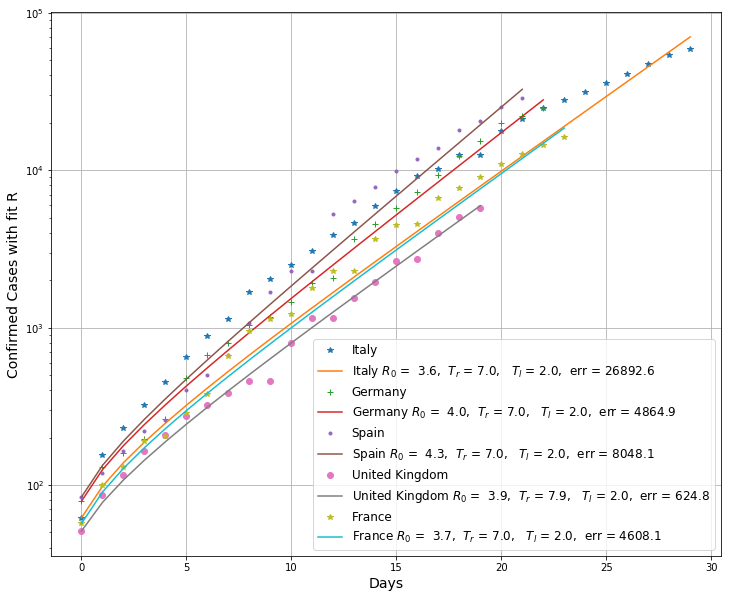

In [47]:
plt.figure(figsize=(12,10))
country='Italy'
population=df_pop[df_pop["Country (or dependency)"]=='Italy']["Population (2020)"].values[0] #'South Korea' #United States
fit_country(country,population)#bounds=([1,0,0],[15,30,15]))
country='Germany'
population=df_pop[df_pop["Country (or dependency)"]=='Germany']["Population (2020)"].values[0] #'South Korea' #United States
fit_country(country,population)#bounds=([1,0,0],[15,30,15]))
#country='China'
#population=df_pop[df_pop["Country (or dependency)"]=='China']["Population (2020)"].values[0] #'South Korea' #United States
#fit_country(country,population)#bounds=([1,0,0],[15,30,15]))
#country='China'
#population=df_pop[df_pop["Country (or dependency)"]=='China']["Population (2020)"].values[0] #'South Korea' #United States
#fit_country(country,population,bounds=([0,0,0],[30,14,14]))
#country='Korea, South'
#population=df_pop[df_pop["Country (or dependency)"]=='South Korea']["Population (2020)"].values[0] #'South Korea' #United States
#fit_country(country,population)#bounds=([1,0,0],[15,30,15]))
#plt.savefig("fit_1.png")
#plt.figure(figsize=(10,10))
#population=df_pop[df_pop["Country (or dependency)"]=='South Korea']["Population (2020)"].values[0] #'South Korea' #United States
#fit_country(country,population,bounds=([0,0,0],[30,14,14]))
#country='US'
#population=df_pop[df_pop["Country (or dependency)"]=='United States']["Population (2020)"].values[0] #'South Korea' #United States
#fit_country(country,population,bounds=([1,0,0],[15,30,15]))
#country='Iran'
#population=df_pop[df_pop["Country (or dependency)"]=='Iran']["Population (2020)"].values[0] #'South Korea' #United Statesfit_country(country,population,bounds=([0,0,0],[30,14,14]))
#fit_country(country,population,bounds=([0,1,1],[30,14,14]))
#plt.savefig("fit_2.png")

#plt.figure(figsize=(10,10))

country='Spain'
population=df_pop[df_pop["Country (or dependency)"]=='Spain']["Population (2020)"].values[0] #'South Korea' #United States
fit_country(country,population)#bounds=([1,0,0],[15,30,15]))
country='United Kingdom'
population=df_pop[df_pop["Country (or dependency)"]=='United Kingdom']["Population (2020)"].values[0] #'South Korea' #United States
fit_country(country,population)#bounds=([1,0,0],[15,30,15]))
country='France'
population=df_pop[df_pop["Country (or dependency)"]=='France']["Population (2020)"].values[0] #'South Korea' #United States
fit_country(country,population)#bounds=([1,0,0],[15,30,15]))
#plt.savefig("fit_3.png")

plt.savefig("fit_EU_new_interpretation_with_bounds.pdf")

# Normalising model

In [75]:
def seir_norm(y,x, R0, Tr, Tl):
    gamma=1./Tr
    beta=R0*gamma
    sigma=1./Tl
    sus = -beta*y[0]*y[2]
    expo = (beta*y[0]*y[2])-sigma*y[1]
    infected = sigma*y[1] - gamma*y[2]
    reco = gamma*y[2]
    return sus, expo, infected, reco
def fit_ode_norm(x,  R0, Tr, Tl):
    return integrate.odeint(seir_norm, (sus0, exp0, inf0, rec0), x, args=( R0, Tr, Tl),atol=1e-16)[:,2]
#integrate.solve_ivp(seir_norm, [sus0, exp0, inf0, rec0], args=( R0, Tr, Tl),method='RK45').y[:,2]
def fit_country_norm(country,population,bounds=([3,1,1], [5,12,12])):
    ydata= df[df["Country"]==country].values[0,1:]
    ydata = np.array(ydata, dtype=float)
    #xdata = np.array(xdata, dtype=float)
    idx=np.where(ydata>100)[0][0]
    ydata=ydata[idx:]
    xdata= np.arange(len(ydata))  #+ idx
#    xdata=xdata[idx:]
    global N, inf0, sus0,rec0,exp0

    #print(xdata,ydata)
    N = population
    inf0 = ydata[0]/N
    exp0= inf0*10
    sus0 = 1 - rec0 - exp0
    rec0 = inf0*.1
    
    popt, pcov = optimize.curve_fit(fit_ode_norm, xdata, ydata/N,bounds=bounds)
    fitted = fit_ode_norm(xdata, *popt)
    err=np.linalg.norm(fitted-ydata)
    la=country, " R0 =  %3.1f " %popt[0], " Tr = %3.1f  "%popt[1], " Tl = %1.1f" %popt[2], " err = %1.1f" %err
    plt.plot(xdata, ydata/N, 'o', mec = 'r',label=country)
    plt.plot(xdata, fitted,label=la)
    plt.legend()
    plt.yscale("log")
  #  print(country, " R0 =  %3.3f \t" %popt[0], ", Tr = %3.3f \t "%popt[1], ", Tl = %3.3E" %popt[2])
   # print(pcov)
   # plt.title(country)



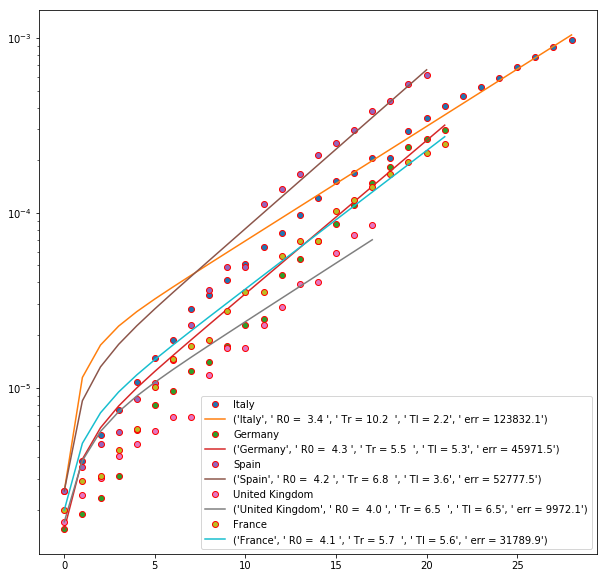

In [78]:
plt.figure(figsize=(10,10))
country='Italy'
population=df_pop[df_pop["Country (or dependency)"]=='Italy']["Population (2020)"].values[0] #'South Korea' #United States
fit_country_norm(country,population)#bounds=([1,0,0],[15,30,15]))
country='Germany'
population=df_pop[df_pop["Country (or dependency)"]=='Germany']["Population (2020)"].values[0] #'South Korea' #United States
fit_country_norm(country,population)#bounds=([1,0,0],[15,30,15]))
#country='China'
#population=df_pop[df_pop["Country (or dependency)"]=='China']["Population (2020)"].values[0] #'South Korea' #United States
#fit_country_norm(country,population)#bounds=([1,0,0],[15,30,15]))
#country='China'
#population=df_pop[df_pop["Country (or dependency)"]=='China']["Population (2020)"].values[0] #'South Korea' #United States
#fit_country_norm(country,population,bounds=([1,1,1],[30,14,14]))
#country='Korea, South'
#population=df_pop[df_pop["Country (or dependency)"]=='South Korea']["Population (2020)"].values[0] #'South Korea' #United States
#fit_country_norm(country,population)#bounds=([1,0,0],[15,30,15]))
#plt.savefig("fit_1.png")
#plt.figure(figsize=(10,10))
#population=df_pop[df_pop["Country (or dependency)"]=='South Korea']["Population (2020)"].values[0] #'South Korea' #United States
#fit_country_norm(country,population,bounds=([0,0,0],[30,14,14]))
#country='US'
#population=df_pop[df_pop["Country (or dependency)"]=='United States']["Population (2020)"].values[0] #'South Korea' #United States
#fit_country_norm(country,population,bounds=([1,0,0],[15,30,15]))
#country='Iran'
#population=df_pop[df_pop["Country (or dependency)"]=='Iran']["Population (2020)"].values[0] #'South Korea' #United Statesfit_country(country,population,bounds=([0,0,0],[30,14,14]))
#fit_country_norm(country,population,bounds=([0,1,1],[30,14,14]))
#plt.savefig("fit_2.png")

#plt.figure(figsize=(10,10))

country='Spain'
population=df_pop[df_pop["Country (or dependency)"]=='Spain']["Population (2020)"].values[0] #'South Korea' #United States
fit_country_norm(country,population)#bounds=([1,0,0],[15,30,15]))
country='United Kingdom'
population=df_pop[df_pop["Country (or dependency)"]=='United Kingdom']["Population (2020)"].values[0] #'South Korea' #United States
fit_country_norm(country,population)#bounds=([1,0,0],[15,30,15]))
country='France'
population=df_pop[df_pop["Country (or dependency)"]=='France']["Population (2020)"].values[0] #'South Korea' #United States
fit_country_norm(country,population)#bounds=([1,0,0],[15,30,15]))
#plt.savefig("fit_3.png")

plt.savefig("fit_EU_normalised.png")

# SIER using minimising least square error
 ref: https://www.kaggle.com/anjum48/seir-model-with-intervention

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from pathlib import Path
#import os
#from tqdm.notebook import tqdm
from scipy.integrate import solve_ivp

def dS_dt(S, I, R_t, T_inf):
    return -(R_t / T_inf) * I * S

# Exposed equation
def dE_dt(S, E, I, R_t, T_inf, T_inc):
    return (R_t / T_inf) * I * S - (T_inc**-1) * E

# Infected equation
def dI_dt(I, E, T_inc, T_inf):
    return (T_inc**-1) * E - (T_inf**-1) * I

# Recovered/deceased equation
def dR_dt(I, T_inf):
    return (T_inf**-1) * I

def SEIR_model(t, y, R_t, T_inf, T_inc):
    
    if callable(R_t):
        reproduction = R_t(t)
    else:
        reproduction = R_t
    
    S, E, I, R = y
    S_out = dS_dt(S, I, reproduction, T_inf)
    E_out = dE_dt(S, E, I, reproduction, T_inf, T_inc)
    I_out = dI_dt(I, E, T_inc, T_inf)
    R_out = dR_dt(I, T_inf)
    return [S_out, E_out, I_out, R_out]

N = 100000  # Population size
n_infected = 1
max_days = 200

# State at time = 0 for SEIR model
a = (N - n_infected)/ N
b = 0
c = n_infected / N
d = 0.
T_inc = 5.2  # average incubation period
T_inf = 2.9  # average infectious period
R_0 = 2.2  # reproduction number without intervention
R_t = 0.7  # reproduction number after intervention
intervention_day = 80

def time_varying_reproduction(t):
    if t > intervention_day:
        return R_t
    else:
        return R_0

sol2 = solve_ivp(SEIR_model, [0, max_days], [a, b, c, d], args=(time_varying_reproduction, T_inf, T_inc), 
                t_eval=np.arange(max_days))

from scipy.optimize import minimize
from sklearn.metrics import mean_squared_log_error, mean_squared_error
